In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import SequentialFeatureSelector as SFS

In [2]:
random_state = 42

In [3]:
df = pd.read_csv("winequality-red.csv")

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [6]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [7]:
df.duplicated().sum()

240

In [8]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

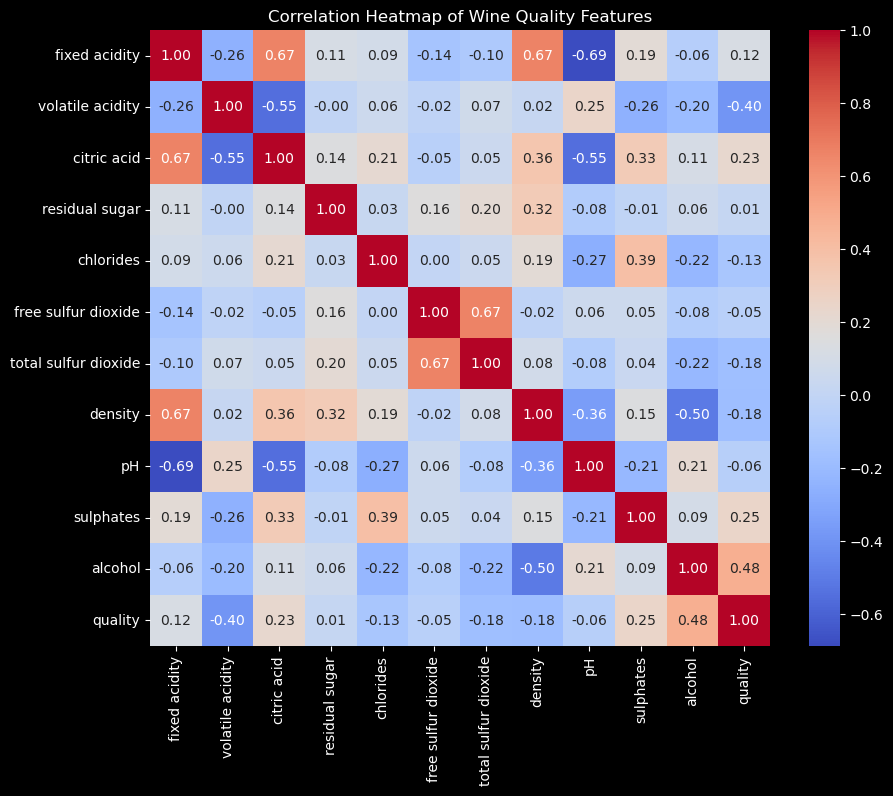

In [9]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Wine Quality Features")
plt.show()


In [10]:
X = df.drop("quality", axis=1)
y = df["quality"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

Ridge score: 0.37021137556816996


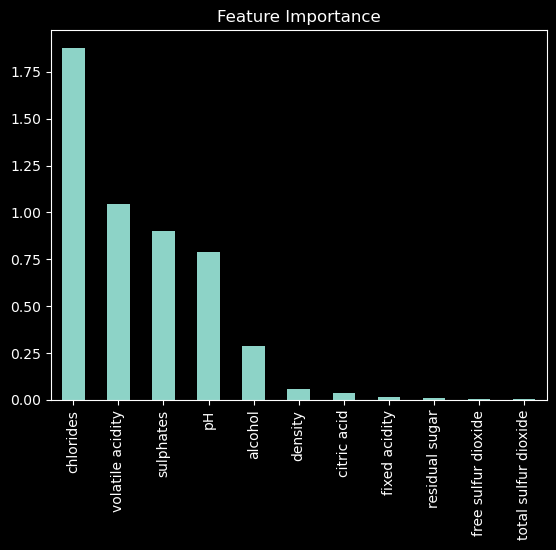

In [11]:
ridge = RidgeCV()
ridge.fit(X_train, y_train)
print(f"Ridge score: {ridge.score(X_test, y_test)}")

pd.Series(np.abs(ridge.coef_), index=X.columns).sort_values(ascending=False).plot(kind="bar")
plt.title("Feature Importance")
plt.show()

In [12]:
sfs = SFS(ridge, tol=1e-2, direction="forward")
sfs.fit(X_train, y_train)
chosen_features = X_train.columns[sfs.get_support()]
print(f"Selected {len(chosen_features)} features: {chosen_features}")

Selected 3 features: Index(['volatile acidity', 'sulphates', 'alcohol'], dtype='object')


In [13]:
X_train_selected = X_train[chosen_features]
X_test_selected = X_test[chosen_features]
ridge_selected = RidgeCV()
ridge_selected.fit(X_train_selected, y_train)
print(f"Ridge score with selected features: {ridge_selected.score(X_test_selected, y_test)}")

Ridge score with selected features: 0.3695296781809225


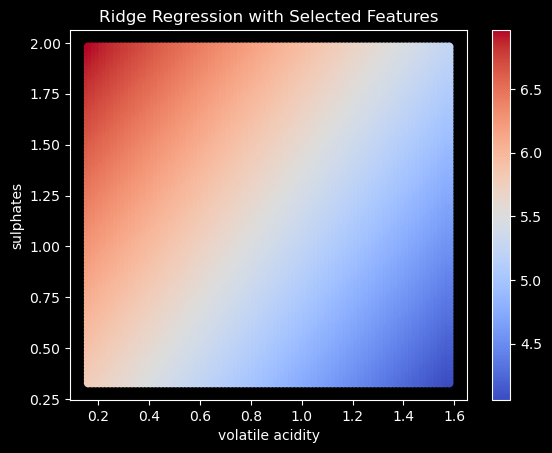

In [14]:
# Calculate the median, maximum, and minimum values of the 'alcohol' feature
median_alcohol = df["alcohol"].median()
max_alcohol = df["alcohol"].max()
min_alcohol = df["alcohol"].min()

# Create a range of values for 'volatile acidity' and 'sulphates' for plotting
volatilite_acidity_range = np.linspace(X_train_selected['volatile acidity'].min(), X_train_selected['volatile acidity'].max(), 100)
sulphates_range = np.linspace(X_train_selected['sulphates'].min(), X_train_selected['sulphates'].max(), 100)

# Generate a grid of values for 'volatile acidity' and 'sulphates'
X_grid = np.array(np.meshgrid(volatilite_acidity_range, sulphates_range)).T.reshape(-1, 2)

# Convert the grid to a DataFrame and add the median alcohol value
X_grid = pd.DataFrame(X_grid, columns=["volatile acidity", "sulphates"])
X_grid["alcohol"] = median_alcohol

# Predict the target variable using the ridge regression model on the grid
y_grid = ridge_selected.predict(X_grid)

# Create a scatter plot of 'volatile acidity' vs 'sulphates' colored by the predicted values
X_grid.plot.scatter(x='volatile acidity', y="sulphates", c=y_grid, cmap="coolwarm", linewidth=2)
plt.title("Ridge Regression with Selected Features")
plt.show()